In [1]:
import os
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk import FreqDist
import text2emotion as te
from LeXmo import LeXmo
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/meghanshubhatt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/meghanshubhatt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/meghanshubhatt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/meghanshubhatt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
myDirectory = 'data/full_speech.txt'
# with open(myDirectory) as f:
#     raw_data = f.readlines()

In [3]:
import textcleaner as tc
data = tc.document(myDirectory) 
#you can also pass list of sentences to the document class constructor.
raw_data = data.remove_stpwrds() #inplace is set to False by default

In [6]:
#Change all to lowercase and remove symbols other than periods
shortword = re.compile(r'\W*\b\w{1,2}\b')
def cleanData(speech):
    speech = speech.lower()
    speech = re.sub("\[*?\-]","",speech)
    #speech = re.sub(r'[^\w\s]', '', speech) 
    speech = re.sub(r'(A|a)pplause', '', speech) 
    speech = shortword.sub('', speech)
    #speech = re.sub(r'\W', ' ', speech)
    # remove all single characters
    speech= re.sub(r'\s+[a-zA-Z]\s+', ' ', speech)
    # Remove single characters from the start
    speech = re.sub(r'\^[a-zA-Z]\s+', ' ', speech) 
    # Substituting multiple spaces with single space
    speech = re.sub(r'\s+', ' ', speech, flags=re.I)
    # Removing prefixed 'b'
    speech = re.sub(r'^b\s+', '', speech)
    speech = re.sub(r"[\([{})\]]", "", speech)
 
    return speech

In [7]:
df = pd.DataFrame(raw_data, columns = ['text']).applymap(lambda x : cleanData(x))

In [8]:
df.head()

,text
0,trump: wow. whoa. that group people. thousands...
1,good evening. thank much speak today lifelong ...
2,"thank opportunity speak you, thank center nati..."
3,thank joining today. this going speech hillary...
4,today like share thoughts stakes election. peo...


In [9]:
processed_sentences = df['text'].tolist()

In [10]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

#Define set of stop words for remaining analysis
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'is', 'the', 'said', 'you','and', 'trump', 'audience', 'members'])


In [11]:
dataEmotion = pd.DataFrame()
count = 0
for speech in processed_sentences:
    emo=LeXmo.LeXmo(speech)
    emo.pop('text', None)
    dft = pd.DataFrame(emo,index = [count])
    dataEmotion = pd.concat([dataEmotion,dft])
    count+=1
print(dataEmotion.head())

      anger  anticipation   disgust      fear       joy  negative  positive  \
0  0.013828      0.033187  0.005992  0.013137  0.026043  0.027887  0.070754   
1  0.025760      0.046235  0.011889  0.035667  0.038309  0.044914  0.065390   
2  0.016202      0.039154  0.005851  0.027903  0.030603  0.054005  0.076058   
3  0.038164      0.023724  0.015988  0.050542  0.013925  0.061888  0.051057   
4  0.025103      0.041077  0.011410  0.031949  0.022364  0.052487  0.063441   

    sadness  surprise     trust  
0  0.014750  0.028578  0.042637  
1  0.025760  0.032365  0.058124  
2  0.013951  0.012601  0.055806  
3  0.030944  0.011862  0.040227  
4  0.026472  0.016431  0.053400  


In [13]:
#Frequency of words in each speech and remove stop words from count
speech_fdist = []
fdist = FreqDist()
for speech in processed_sentences:
    for sentence in sent_tokenize(speech):
        sentence = re.sub(r'\b\w{1,2}\b', '', sentence)
        sentence = re.sub(r'[^\w]', ' ', sentence)
        for word in word_tokenize(sentence):
            if word not in stop_words: 
                fdist[word] += 1
    speech_fdist.append(fdist)
    fdist = FreqDist()

In [14]:
fFreq = {'Speech': processed_sentences,'Speech Word Frequency':speech_fdist }
dfData = pd.concat([pd.DataFrame(fFreq), dataEmotion], axis=1)

In [15]:
dfData.head()

,Speech,Speech Word Frequency,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,trump: wow. whoa. that group people. thousands...,"{'wow': 1, 'whoa': 1, 'group': 2, 'people': 55...",0.013828,0.033187,0.005992,0.013137,0.026043,0.027887,0.070754,0.014750,0.028578,0.042637
1,good evening. thank much speak today lifelong ...,"{'good': 1, 'evening': 1, 'thank': 10, 'much':...",0.025760,0.046235,0.011889,0.035667,0.038309,0.044914,0.065390,0.025760,0.032365,0.058124
2,"thank opportunity speak you, thank center nati...","{'thank': 3, 'opportunity': 2, 'speak': 1, 'ce...",0.016202,0.039154,0.005851,0.027903,0.030603,0.054005,0.076058,0.013951,0.012601,0.055806
3,thank joining today. this going speech hillary...,"{'thank': 2, 'joining': 1, 'today': 4, 'going'...",0.038164,0.023724,0.015988,0.050542,0.013925,0.061888,0.051057,0.030944,0.011862,0.040227
4,today like share thoughts stakes election. peo...,"{'today': 2, 'like': 4, 'share': 3, 'thoughts'...",0.025103,0.041077,0.011410,0.031949,0.022364,0.052487,0.063441,0.026472,0.016431,0.053400


Speech ->  1


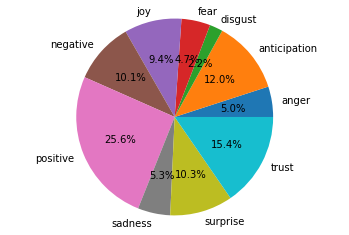

Speech ->  2


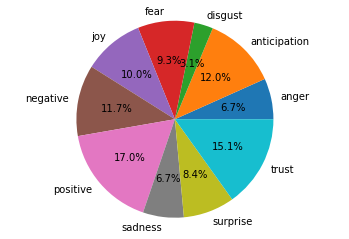

Speech ->  3


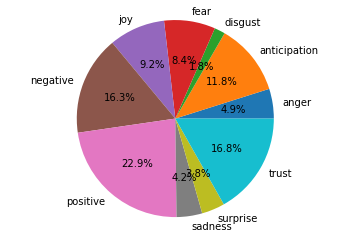

Speech ->  4


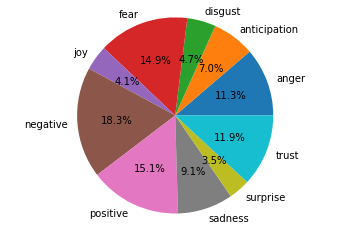

Speech ->  5


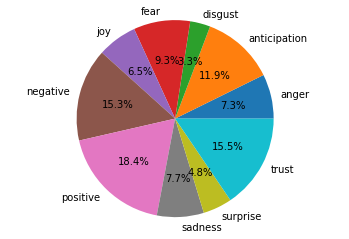

Speech ->  6


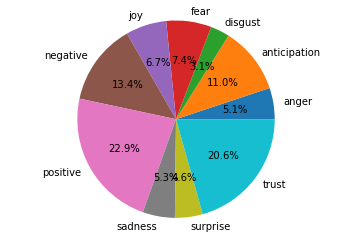

Speech ->  7


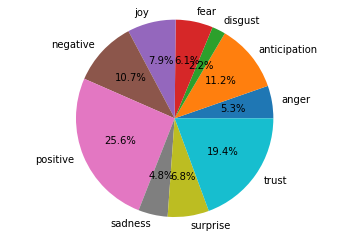

Speech ->  8


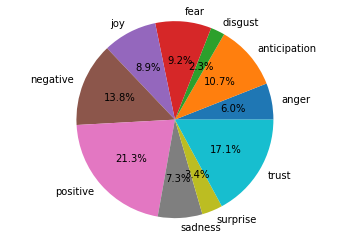

Speech ->  9


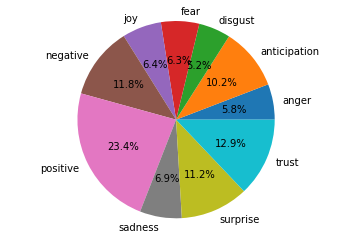

Speech ->  10


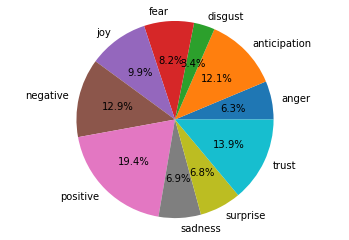

Speech ->  11


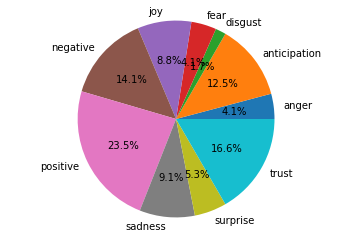

Speech ->  12


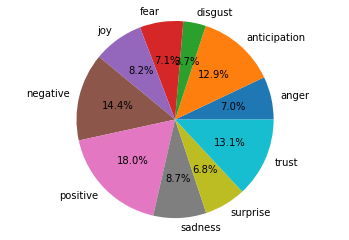

Speech ->  13


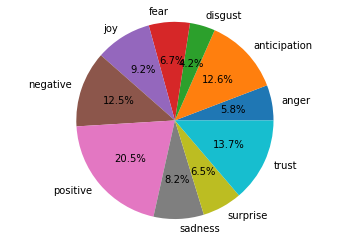

Speech ->  14


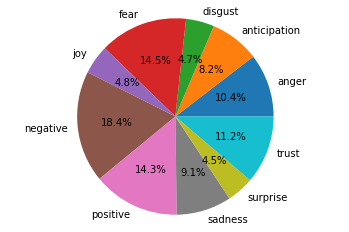

Speech ->  15


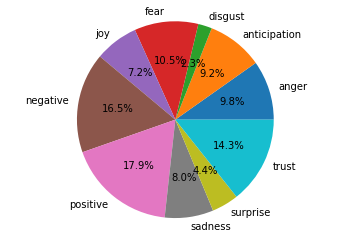

Speech ->  16


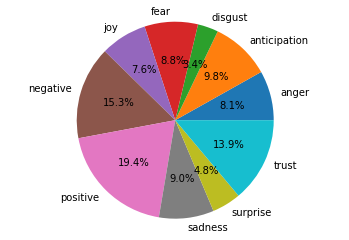

Speech ->  17


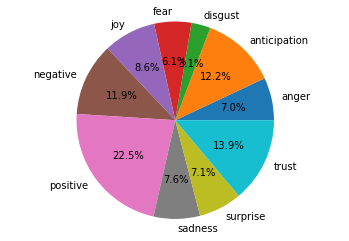

Speech ->  18


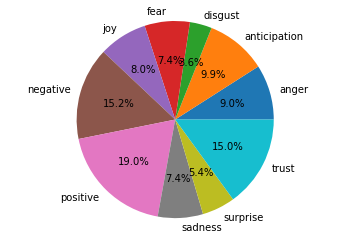

Speech ->  19


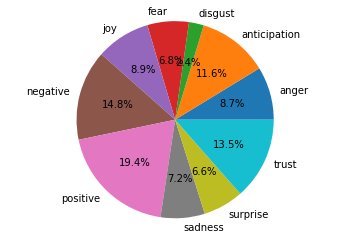

Speech ->  20


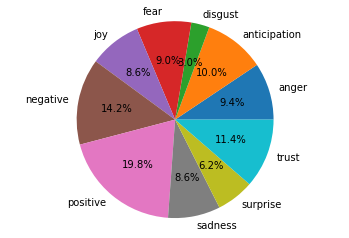

Speech ->  21


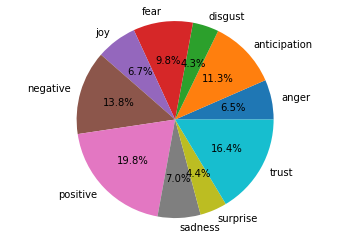

Speech ->  22


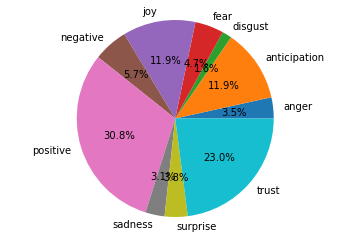

Speech ->  23


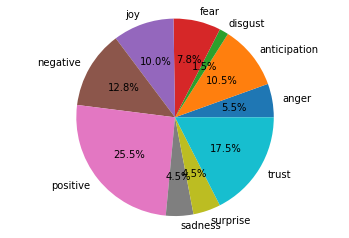

Speech ->  24


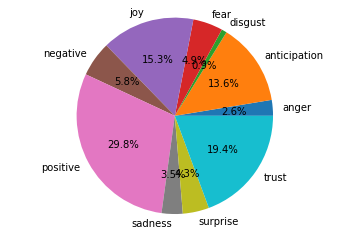

Speech ->  25


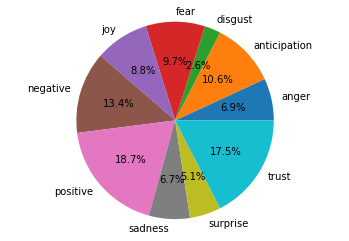

Speech ->  26


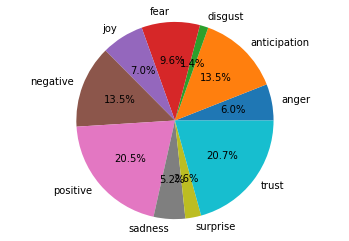

Speech ->  27


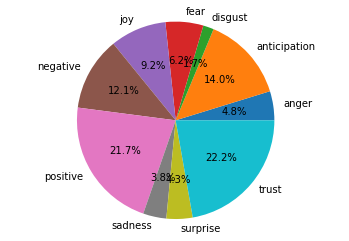

Speech ->  28


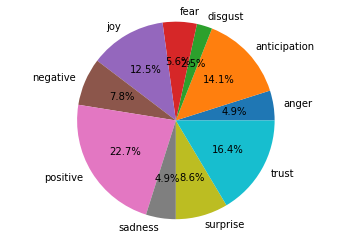

Speech ->  29


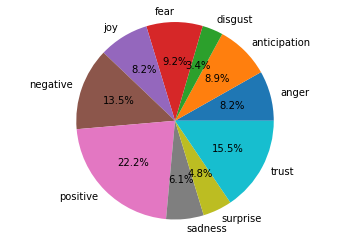

Speech ->  30


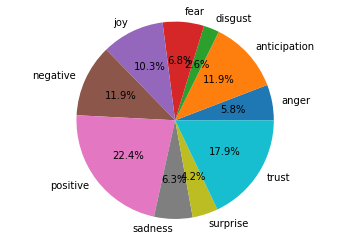

Speech ->  31


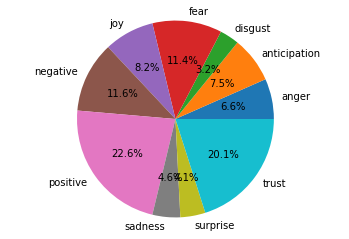

Speech ->  32


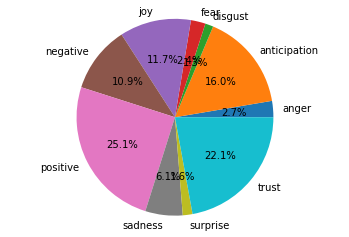

Speech ->  33


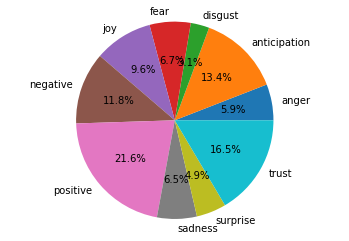

Speech ->  34


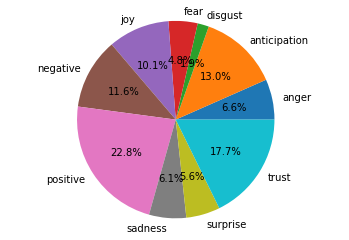

Speech ->  35


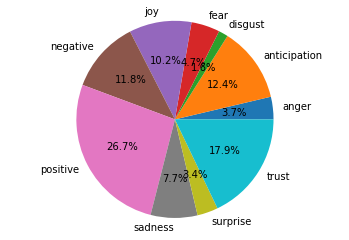

Speech ->  36


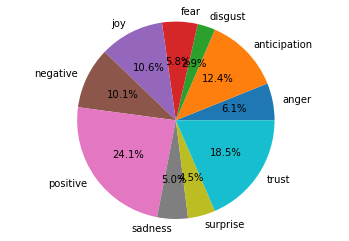

Speech ->  37


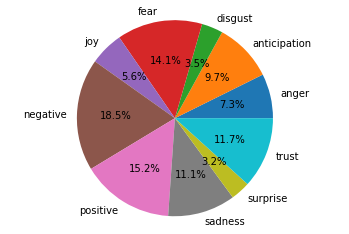

Speech ->  38


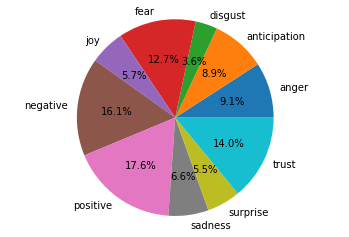

Speech ->  39


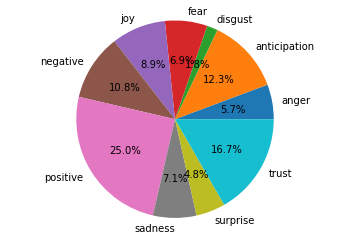

Speech ->  40


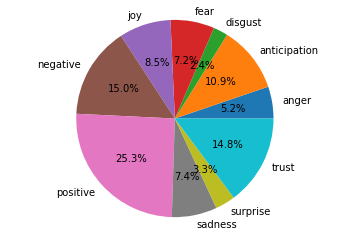

Speech ->  41


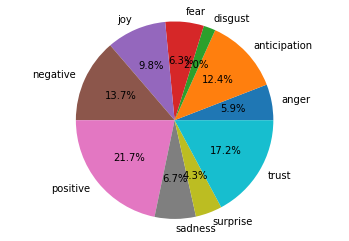

Speech ->  42


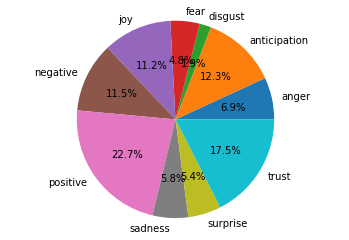

Speech ->  43


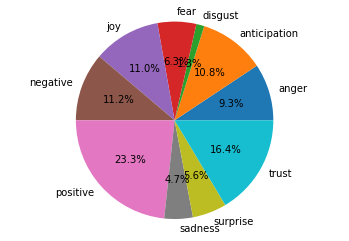

Speech ->  44


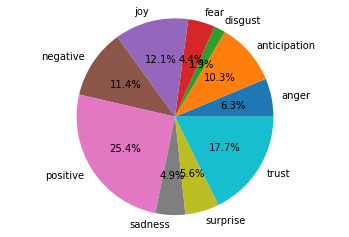

Speech ->  45


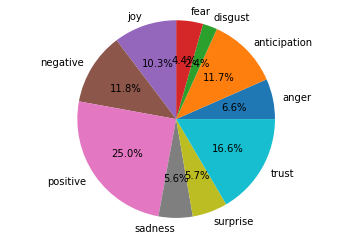

Speech ->  46


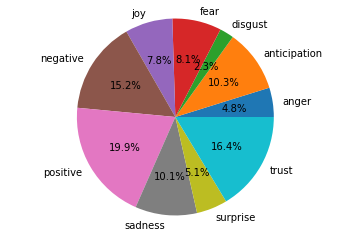

Speech ->  47


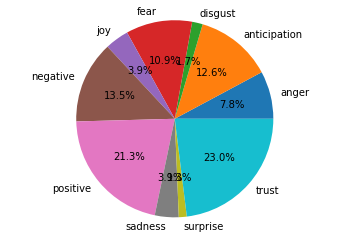

Speech ->  48


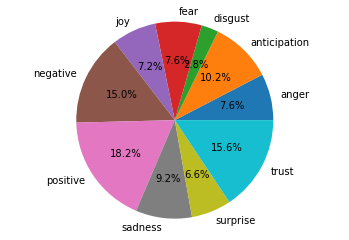

Speech ->  49


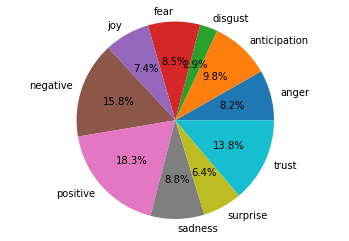

Speech ->  50


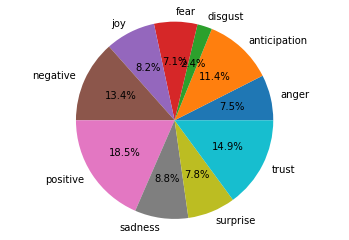

Speech ->  51


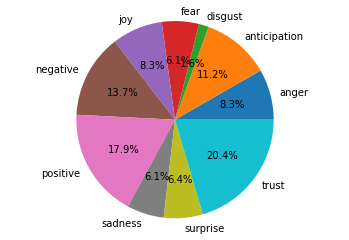

Speech ->  52


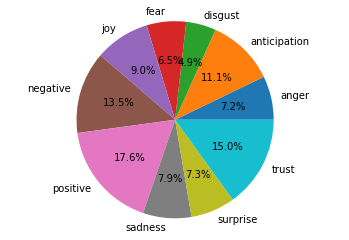

Speech ->  53


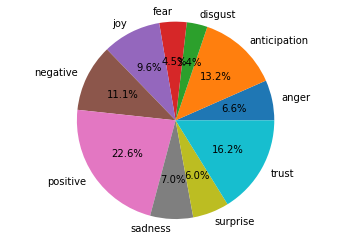

Speech ->  54


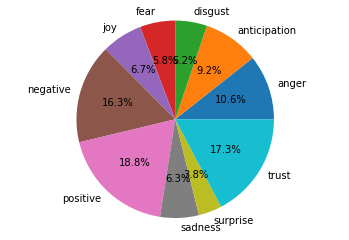

Speech ->  55


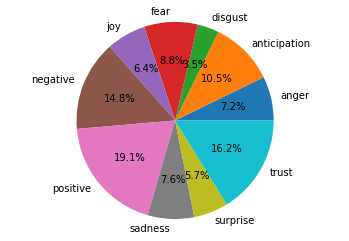

Speech ->  56


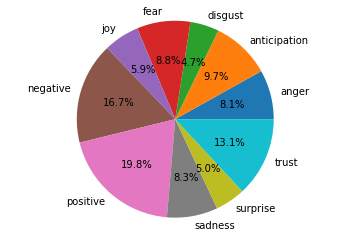

Speech ->  57


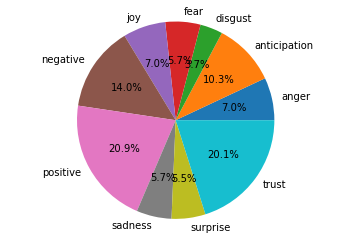

Speech ->  58


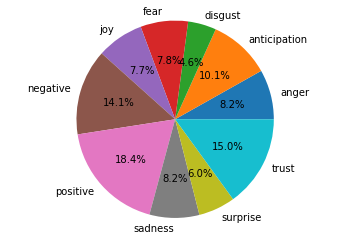

Speech ->  59


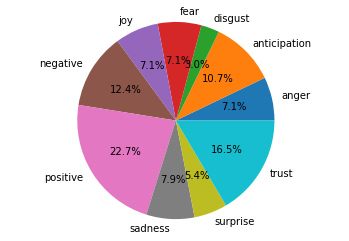

Speech ->  60


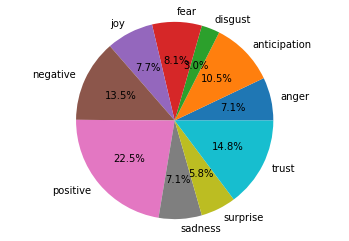

Speech ->  61


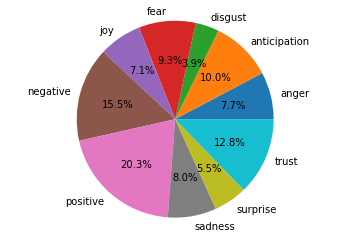

Speech ->  62


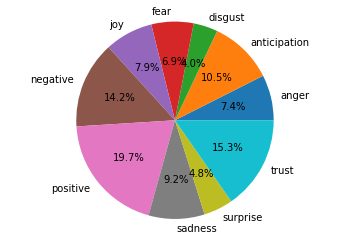

Speech ->  63


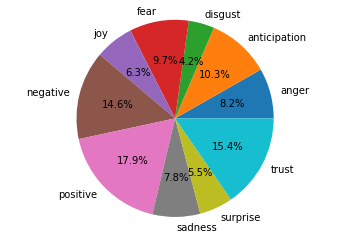

Speech ->  64


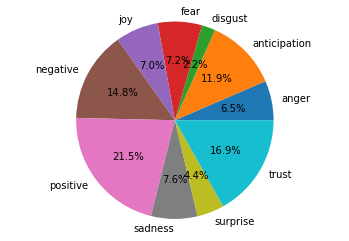

Speech ->  65


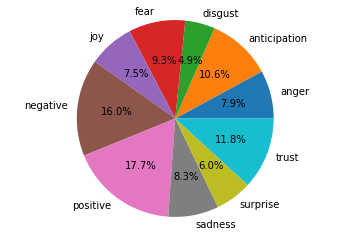

Speech ->  66


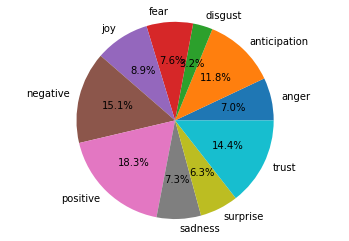

Speech ->  67


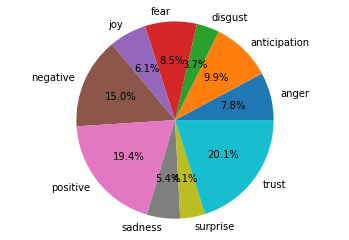

Speech ->  68


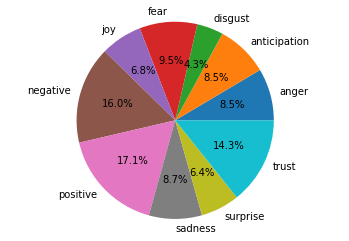

Speech ->  69


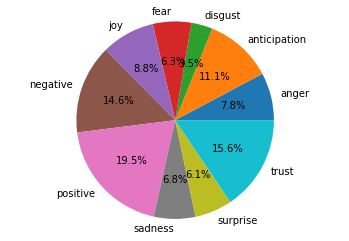

Speech ->  70


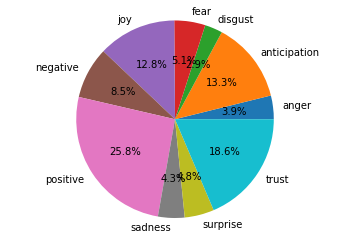

Speech ->  71


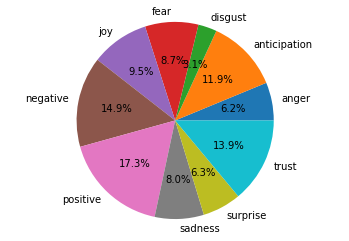

Speech ->  72


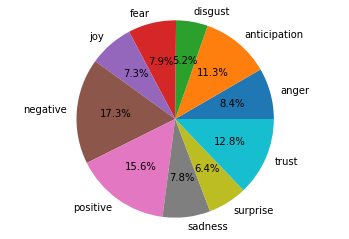

Speech ->  73


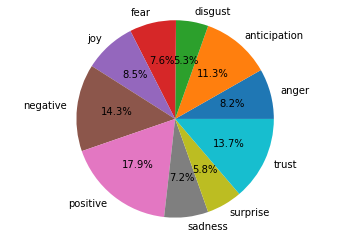

Speech ->  74


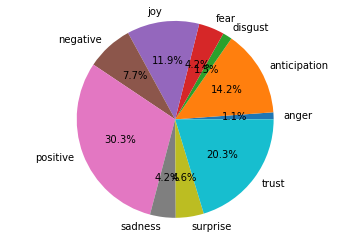

In [16]:
#Plot charts to visualize speech sentiment
labels = 'anger','anticipation', 'disgust','fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust'

for i in range(len(dfData)) :
    print("Speech -> ", i+1)
    anger = dfData.iloc[i,2] * 100
    anticipation = dfData.iloc[i,3] * 100
    disgust = dfData.iloc[i,4] * 100
    fear = dfData.iloc[i,5] * 100
    joy = dfData.iloc[i,6] * 100
    negative = dfData.iloc[i,7] * 100
    positive = dfData.iloc[i,8] * 100
    sadness = dfData.iloc[i,9] * 100
    surprise = dfData.iloc[i,10] * 100
    trust = dfData.iloc[i,11] * 100
    sizes = [anger,anticipation,disgust,fear, joy, negative, positive, sadness, surprise, trust]
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.show()

Text(0.5, 1.0, 'Distribution of number of words in each sentence')

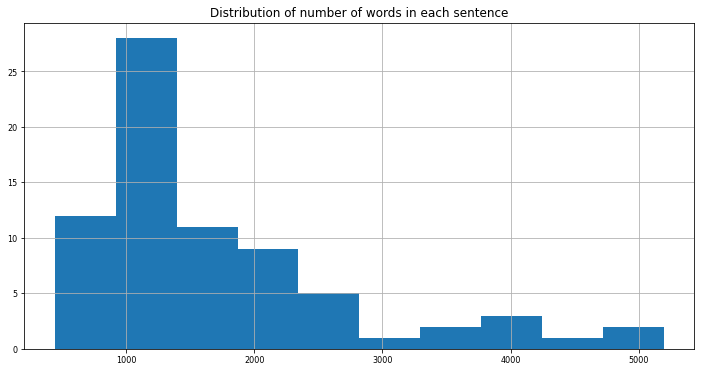

In [17]:
dfData['NumWords'] = dfData['Speech'].apply(lambda x: len(x.split()))
dfData[['NumWords']].hist(figsize=(12, 6), bins=10, xlabelsize=8, ylabelsize=8);
plt.title("Distribution of number of words in each sentence")

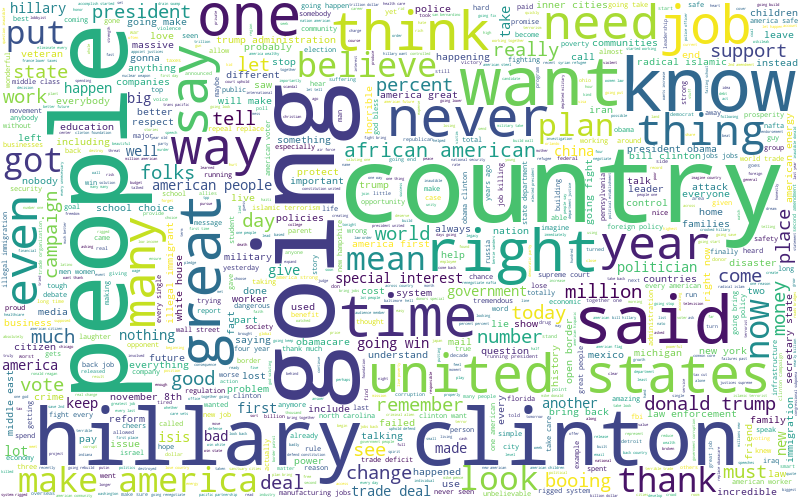

In [18]:
from wordcloud import WordCloud

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=500, max_font_size=110, background_color="white", max_words=3000, contour_width=3, contour_color='steelblue')

all_words = ''.join([word for word in dfData['Speech']]).replace('\n', '.')

# Generate a word cloud
wordcloud.generate(all_words)

# Visualize the word cloud
wordcloud.to_image()

In [19]:
import re
NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')
def normalize_texts(texts):
    normalized_texts = ''
    lower = texts.lower()
    no_punctuation = NON_ALPHANUM.sub(r' ', lower)
    no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
    return no_non_ascii
  
dfData['SpeechNormalize'] = dfData['Speech'].apply(normalize_texts)
dfData['SpeechNormalize'] = dfData['SpeechNormalize'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

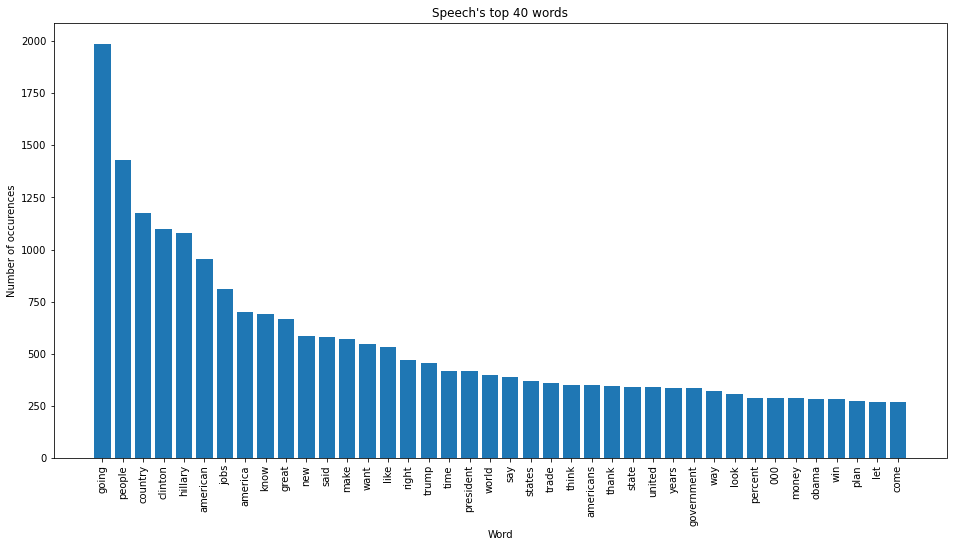

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def get_top_n_words(corpus, n=10):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

words = []
word_values = []
for i,j in get_top_n_words(dfData['SpeechNormalize'], 40):
    words.append(i)
    word_values.append(j)
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title("Speech's top 40 words");
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [21]:
dfData.to_csv('data/data.csv',index=False)

In [22]:
dfData.shape

(74, 14)